# Learning  discrete Lagrangian for cartpend

This notebook studies learning the discrete lagrangian the cart pendulum system in a self-contained and continuous manner using the various modules implemented in the project repo.

In [1]:
# General imports
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jaxopt
import numpy as np
from jax.experimental.ode import odeint
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)

# import our modules
from model_new_loss import NNLearner
from dataset_generator import TrajectoryDataset

## System configuration

In [2]:
# Set system
from systems.system_pendcart import lagrangian_pendcart, solve_lagrangian_autograd, hamiltonian_pendcart
from jax import jit
target = 'tripple'
learning = 'Ld'    

N = 200
N_simul_after_learning = 300 #must be larger than N
num_epochs = 100000

stepsize = 0.01
test_every_choice = 10

weight_loss_choice = 1
weight_cond_choice = 0 
weight_degeneracy = 1 # 0.9

dof = 2
system_lagrangian = lagrangian_pendcart

x0 =  np.array([0.1, 0.1, 0, 0], dtype=np.float64) 
x0_test = np.array([-1.1, -0.1, 0.1, -0.1], dtype=np.float64) 
q0_train, v0_train = jnp.split(x0, 2)
p0_train = jax.grad(system_lagrangian,argnums = 1)(q0_train, v0_train)

q0_test, v0_test = jnp.split(x0_test, 2)
p0_test = jax.grad(system_lagrangian,argnums = 1)(q0_test, v0_test)

base_point = (0*q0_train, 0*q0_train, jnp.ones((dof))*10) 
base_point_tripple = base_point

(DeviceArray([0., 0.], dtype=float64), DeviceArray([0., 0.], dtype=float64), DeviceArray([10., 10.], dtype=float64))


### Generate trajectories using solvers to be used for dataset generation later

In [3]:
from SVI_integrators import SVI_solver_TQs
from utils import f2c_trajectory

def discrete_lagrangian_orig(qk, qk_1, h):
    return h*system_lagrangian((qk+qk_1)/2,(qk_1-qk)/h)

proportion_f2c = int(stepsize/0.0001)
train_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)
test_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_test, p0_test)

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.50it/s]

The train trajectory has shape (201, 4) with dtype float64
The test trajectory has shape (201, 4) with dtype float64


Text(0.5, 1.0, 'comparing how different the test and train trajs are')

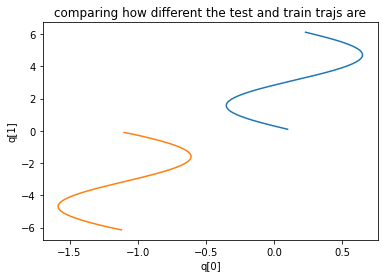

In [4]:
plt.plot(train_trajectory[:,0], train_trajectory[:,1], label="train traj")
plt.plot(test_trajectory[:,0], test_trajectory[:,1], label="test traj")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('comparing how different the test and train trajs are')

## Dataset generation from trajectories

In other words map the analytically generated trajectory into a dataset of (input, target) observation tuples to be used for training our model. Note there are different (input, target) observations generated based on the `mode` parameter of the `TrajectoryDataset` instantiation.

The `TrajectoryDataset` extends `torch.utils.data.Dataset` and hence has the same behaviour (API) with some additional attributes. Supports index based subscript access to the dataset. 

In [7]:
train_dataset = TrajectoryDataset(input_trajectory=train_trajectory, 
    mode="tripple_Ld", lagrangian=system_lagrangian, np_mode=True)
test_dataset = TrajectoryDataset(input_trajectory=test_trajectory, 
    mode="tripple_Ld", lagrangian=system_lagrangian, np_mode=True)

199

## Instantiating and fitting a neural network model

In the cell below we specify the `NNLearner` which involves specifying: the functional model (architecture of the network), the optimiser (and any hyperparameters it will have, the train and test dataset, the loss function to be used, and any additional hyperparameters.

To specify the functional model modify the arguments of the `stax.serial` function below, which will be passed into the `NNLearner` via the `stax` argument.

Specification of the optimiser is done via two arguments to the `NNLearner`: the `optimizer` str argument which expects the name of the optimiser to be used (currently only "adam" and "sgd"), the other argument is the `optimizer_parameters` which are any additional hyperparameters passed into the internal `optimisers.<adam/sgd>` instantiation. 

In [8]:
from jax.example_libraries import stax
from jax.example_libraries import optimizers

stax_nn = stax.serial(
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(1),
        )
optimizer_parameters = lambda t: jnp.select([t < 1000, t > 2000, t > 3000, t > 4000, t > 5000, t > 8000, t > 10000, t > 12000, t > 18000, t > 25000, t>70000], [3e-3, 3e-4, 3e-5, 3e-6, 3e-7, 3e-7, 3e-7, 3e-8, 3e-8, 3e-6, 3e-8])

model = NNLearner(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    loss="tripple_Ld",
    h=stepsize,
    stax=stax_nn,
    dof=dof,
    input_shape=2 * dof,
    weight_loss=weight_loss_choice,
    weight_cond=weight_cond_choice,
    weight_degeneracy=weight_degeneracy,
    base_point_tripple=base_point_tripple,
    optimizer="adam",
    optimizer_parameters = optimizer_parameters
)

params, train_losses_record, test_losses_record = model.fit2( 
    num_epochs=num_epochs, test_every=test_every_choice
)


## Learning the lagrangian


Epochs progress: 100%|████████████████| 100000/100000 [1:04:44<00:00, 25.74it/s]


### Plot the training and test loss over the epochs (x ticks according to recorded steps)

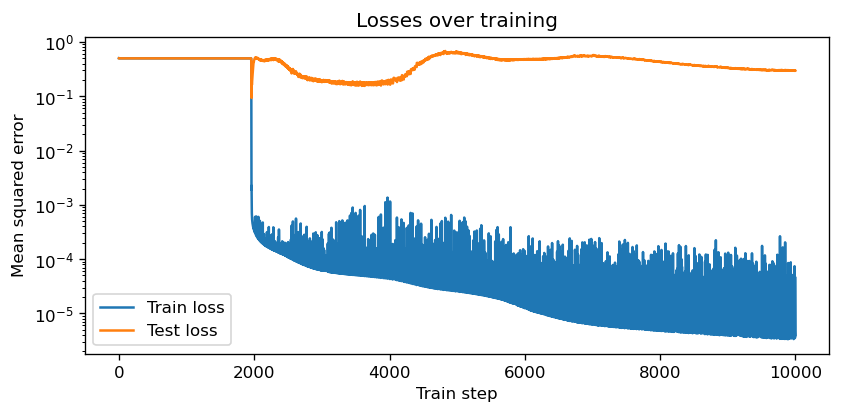

In [9]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses_record, label='Train loss')
plt.plot(test_losses_record, label='Test loss')
plt.yscale('log')

plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

In [ ]:
#####
##### Plotting training related loss terms
#####
cm = 1/2.54
fig, axs = plt.subplots(3, figsize=(30*cm, (3*15)*cm))
fig.suptitle('Training and loss related terms')

# Plotting loss curve
# plt.figure(figsize=(8, 3.5), dpi=120)
axs[0].plot(train_losses_record, label='Train loss')
axs[0].plot(test_losses_record, label='Test loss')
# axs[0].set_yscale('log')
axs[0].set_title('Full Loss over training')
axs[0].set(xlabel = "Train step", ylabel = "Full Loss")
axs[0].legend()

# Plot the MSE component of the loss curve
axs[1].plot(model.mse_losses, label='MSE train term')
axs[1].set_title('MSE over training')
axs[1].set_yscale('log')
axs[1].set(xlabel = "Train step", ylabel = "MSE")
axs[1].legend()                                  

# Plot the degeneracy component of the loss curve
axs[2].plot(model.degeneracy_values, label='degeneracy train term')
axs[2].set_title('Degeracy over training')
axs[2].set_yscale('log')
axs[2].set(xlabel = "Train step", ylabel = "degeneracy")
axs[2].legend()    

In [11]:
def Ldk(q_k, q_k1):
    return  model.learned_lagrangian(params) (q_k,q_k1)
def D2Ld1k(q_1k, q_k): 
    return jax.grad(Ldk, argnums=1)(q_1k, q_k)
def D1Ldk(q_k, q_k1):  
    return jax.grad(Ldk, argnums=0)(q_k, q_k1)

result = np.zeros((dof,10-1))
mse  = np.zeros((1,10-1))

for k in range(0,10-1):

    q_1k = train_trajectory[k,0:dof]
    q_k = train_trajectory[k+1,0:dof]
    q_k1 = train_trajectory[k+2,0:dof]

    def D2_D1Ldk(q_k, q_k1):
        return jax.jacrev(D1Ldk, argnums=1)(q_k, q_k1)

    print(np.linalg.eigvals(D2_D1Ldk(q_k, q_k1)))

    result[:,k] = D2Ld1k(q_1k, q_k) + D1Ldk(q_k, q_k1)
    print(result[:,k])

[81.29547292 18.17549489]
[-0.00146233 -0.00114947]
[81.32198699 18.17893491]
[-0.00138299 -0.00110751]
[81.34967536 18.18241336]
[-0.00130133 -0.00106702]
[81.37859462 18.18593358]
[-0.00121728 -0.00102785]
[81.40880337 18.18949871]
[-0.00113083 -0.00098983]
[81.44036234 18.19311163]
[-0.001042   -0.00095279]
[81.47333444 18.19677497]
[-0.00095086 -0.00091653]
[81.50778489 18.20049107]
[-0.00085751 -0.00088084]
[81.54378132 18.20426199]
[-0.00076208 -0.00084552]


# Simulating (trying to recreate) the train trajectory using the learnt Lagrangian and predicting future behaviour

MAKING THE DISCRETE APPROX OF THE LEARNT Ld

In [12]:
def discrete_lagrangian_based_on_NN(qk,qk_1,h): ## here because we have learnt Ld we do not need to do much
    return model.learned_lagrangian(params)(qk,qk_1)


First we try to recreate the train trajectory which is N steps long

100%|█████████████████████████████████████████| 199/199 [04:25<00:00,  1.33s/it]


Text(0.5, 1.0, 'q[0] vs q[1] evolution, recreating the train trajectory')

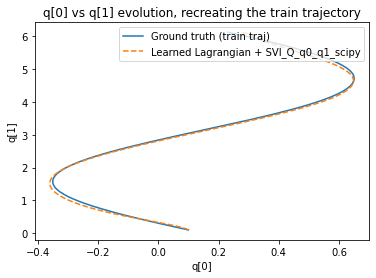

In [13]:
### SVI Q INTEGRATOR, TAKING q0 and q1 AS INITIAL DATA AND SCIPY ROOT FINDERS
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]

q_model_SVI_Q_q0_q1_scipy, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N,"hybr")
q_model_SVI_Q_q0_q1_scipy2 =q_model_SVI_Q_q0_q1_scipy.T

#plot
plt.plot(train_trajectory[:,0],train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],q_model_SVI_Q_q0_q1_scipy2[:,1],'--', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution, recreating the train trajectory')

Text(0.5, 1.0, 'q[0]  evolution, recreating the train trajectory')

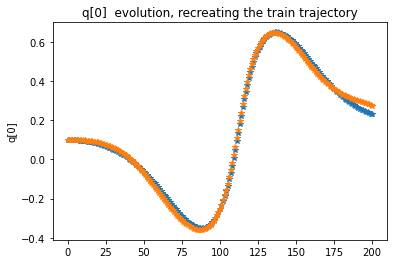

In [14]:
plt.plot(train_trajectory[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')
plt.title('q[0]  evolution, recreating the train trajectory')

Text(0.5, 1.0, ' q[1] evolution, recreating the train trajectory')

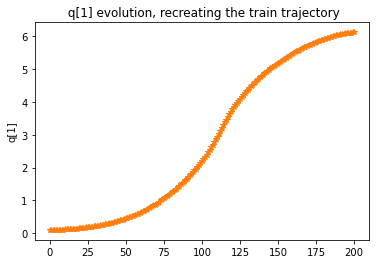

In [15]:
plt.plot(train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title(' q[1] evolution, recreating the train trajectory')

Nex we try to recreate the train trajectory and also predict for additional steps with a total stels of N_simul_after_learning 

100%|█████████████████████████████████████████| 299/299 [03:58<00:00,  1.25it/s]


Text(0.5, 1.0, 'q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

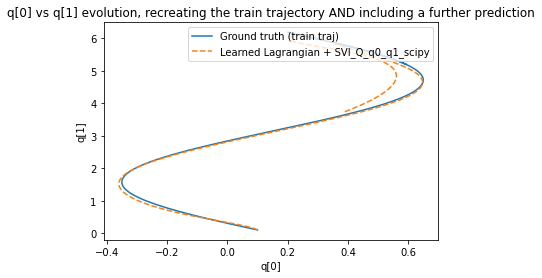

In [39]:
### SVI Q INTEGRATOR, TAKING q0 and q1 AS INITIAL DATA AND SCIPY ROOT FINDERS
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
N_simul_after_learning = 300
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]

train_trajectory_extra = f2c_trajectory(proportion_f2c, stepsize, N_simul_after_learning, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)

q_model_SVI_Q_q0_q1_scipy_extra, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N_simul_after_learning,"hybr")
q_model_SVI_Q_q0_q1_scipy_extra2 =q_model_SVI_Q_q0_q1_scipy_extra.T

#plot
plt.plot(train_trajectory_extra[:,0],train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],q_model_SVI_Q_q0_q1_scipy_extra2[:,1],'--', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[0] evolution, recreating the train trajectory AND including a further prediction')

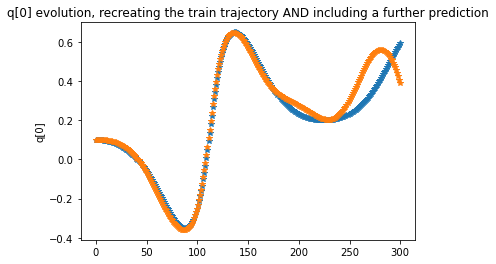

In [40]:
plt.plot(train_trajectory_extra[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')
plt.title('q[0] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[1] evolution, recreating the train trajectory AND including a further prediction')

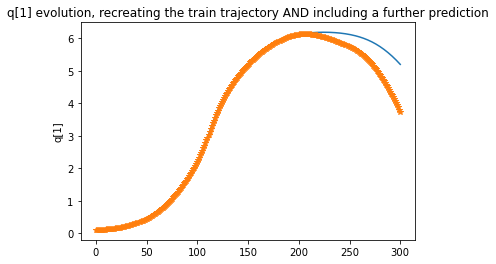

In [41]:
plt.plot(train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title('q[1] evolution, recreating the train trajectory AND including a further prediction')

In this example the symmetry I = p^T w due to w=[1 0] equals p[0]. Thus the presence of this symmetry means that the 0 element of p should be conserved. 

In the folowing tests when we refer to tajc computed from the learnt LD we use our recreation of the train trajectory and in the second part it plus an extended prediction on which we have not trained previously.


In [48]:
from jax import jit,grad
from SVI_funcs import SVI_funcs

def pm_calc_orig(q,v):
    return  jax.grad(system_lagrangian ,argnums = 1)(q,v)  
pm_calc_orig_jitted = jit(pm_calc_orig)

def learned_continuous_Lagrangian(q,qdot): 
    q0 = q-stepsize/2*qdot
    q1 = q+stepsize/2*qdot    
    return model.learned_lagrangian(params)(q0,q1)/stepsize

L_backward  = lambda q,qdot: L_BEA2d(learned_continuous_Lagrangian,stepsize)(jnp.hstack([q,qdot]))

def pm_calc_bea(q,v):
    return  jax.grad(L_backward, argnums = 1)(q,v)  
pm_calc_bea_jitted = jit(pm_calc_bea)

def D1Ldk_learned(qk,qk1,h): 
    return grad(model.learned_lagrangian(params), argnums=0)(qk,qk1) #or D2Ld1k(qk,qk1,h)

def calculating_velocity_based_on_bea(num_steps, traj, v0_start,cont_lagrangian_func):
    v=np.zeros((dof, num_steps+1))
    def momentum_equation(qdot_k, qk, qk_1):
        righthand = jax.grad(cont_lagrangian_func, argnums = 1)(qk, qdot_k) # ask christian for qk
        lefthand = -D1Ldk_learned(qk, qk_1, stepsize)
        
        return righthand- lefthand
    
    v[:,0] = v0_start

    for k in range(1, num_steps):
        qk = traj[:,k]
        qk_1 = traj[:,k+1]
        def momentum_equation_new(qdot):
            return momentum_equation(qdot, qk, qk_1)
        srf = jaxopt.ScipyRootFinding(method='hybr', jit=False, implicit_diff_solve=None, has_aux=False, optimality_fun=momentum_equation_new)
        v[:,k] = srf.run(v[:,k-1])[0]
    
    return v

def calculating_velocity_based_on_bea_Llearnt(num_steps, traj, v0_start):
    return calculating_velocity_based_on_bea(num_steps, traj, v0_start,learned_continuous_Lagrangian)
#calculating_velocity_based_on_bea_Llearnt = jit(calculating_velocity_based_on_bea_Llearnt)

def getting_p_conservation_test(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start,naming_info):
    #v0_start = v0_train
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T
    vlearnt_bea = calculating_velocity_based_on_bea_Llearnt(number_steps, traj_from_learnt_Ld, v0_start)

    p_Lorig_qorig_vorigCD = np.zeros((dof,number_steps))
    p_Lorig_qorig_vorigCD[:,0] = pm_calc_orig_jitted(orig_traj[:,0],v0_start)  
    for k in range(1, number_steps):
        print(k)
        vk =  (-orig_traj[:,k-1]+orig_traj[:,k+1])/2/stepsize
        qk = orig_traj[:,k]
        p_Lorig_qorig_vorigCD[:,k] = pm_calc_orig_jitted(qk,vk)

    p_Lorig_qlearnt_vlearntCD = np.zeros((dof,number_steps))
    p_Lorig_qlearnt_vlearntCD[:,0] = pm_calc_orig_jitted(traj_from_learnt_Ld[:,0],v0_start)  
    for k in range(1, number_steps):
        print(k)
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        p_Lorig_qlearnt_vlearntCD[:,k] = pm_calc_orig_jitted(qk,vk)

        
    p_Lorig_qlearnt_vlearntBEA = np.zeros((dof,number_steps))
    p_Lorig_qlearnt_vlearntBEA[:,0] = pm_calc_orig_jitted(traj_from_learnt_Ld[:,0],v0_start)  
    for k in range(1, number_steps):
        print(k)
        qk = traj_from_learnt_Ld[:,k]
        p_Lorig_qlearnt_vlearntBEA[:,k] = pm_calc_orig_jitted(qk,vlearnt_bea[:,k])
   
    
    plt.plot(p_Lorig_qorig_vorigCD[0,:], label="p_Lorig_qorig_vorigCD")
    plt.plot(p_Lorig_qlearnt_vlearntCD[0,:], label="p_Lorig_qlearnt_vlearntCD")
    plt.plot(p_Lorig_qlearnt_vlearntBEA[0,:], label="p_Lorig_qlearnt_vlearntBEA")
    plt.legend(loc="upper left")
    plt.ylabel('p[0]')
    plt.title('p[0] comparison'+naming_info)

    return p_Lorig_qorig_vorigCD,p_Lorig_qlearnt_vlearntCD,p_Lorig_qlearnt_vlearntBEA,vlearnt_bea




Testing first with the recreated traintrajectory

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


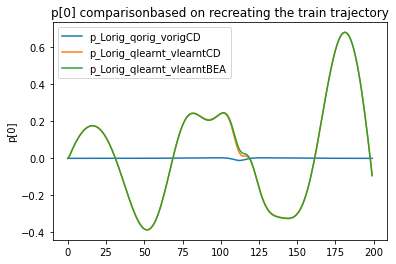

In [49]:
p_Lorig_qorig_vorigCD,p_Lorig_qlearnt_vlearntCD,p_Lorig_qlearnt_vlearntBEA,vlearnt_bea = getting_p_conservation_test(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train,'based on recreating the train trajectory')


0.0
0.0
0.0


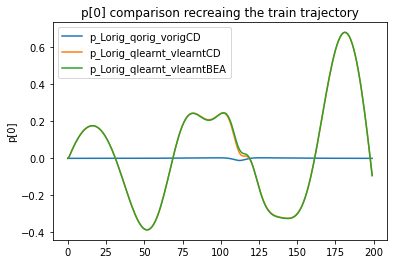

In [50]:
plt.plot(p_Lorig_qorig_vorigCD[0,:], label="p_Lorig_qorig_vorigCD")
plt.plot(p_Lorig_qlearnt_vlearntCD[0,:], label="p_Lorig_qlearnt_vlearntCD")
plt.plot(p_Lorig_qlearnt_vlearntBEA[0,:], label="p_Lorig_qlearnt_vlearntBEA")
plt.legend(loc="upper left")
plt.ylabel('p[0]')
plt.title('p[0] comparison recreaing the train trajectory')

print(p_Lorig_qorig_vorigCD[0,0])
print(p_Lorig_qlearnt_vlearntCD[0,0])
print(p_Lorig_qlearnt_vlearntBEA[0,0])




    Now with extra predctions

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


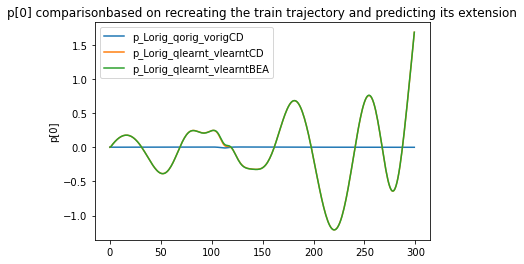

In [51]:
p_Lorig_qorig_vorigCD_extra,p_Lorig_qlearnt_vlearntCD_extra,p_Lorig_qlearnt_vlearntBEA_extra,vlearnt_bea_extra = getting_p_conservation_test(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train,'based on recreating the train trajectory and predicting its extension')


0.0
0.0
0.0


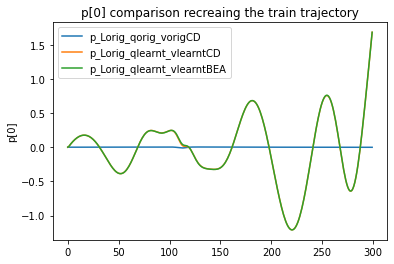

In [52]:
plt.plot(p_Lorig_qorig_vorigCD_extra[0,:], label="p_Lorig_qorig_vorigCD")
plt.plot(p_Lorig_qlearnt_vlearntCD_extra[0,:], label="p_Lorig_qlearnt_vlearntCD")
plt.plot(p_Lorig_qlearnt_vlearntBEA_extra[0,:], label="p_Lorig_qlearnt_vlearntBEA")
plt.legend(loc="upper left")
plt.ylabel('p[0]')
plt.title('p[0] comparison recreaing the train trajectory')

print(p_Lorig_qorig_vorigCD_extra[0,0])
print(p_Lorig_qlearnt_vlearntCD_extra[0,0])
print(p_Lorig_qlearnt_vlearntBEA_extra[0,0])


0.0
0.0
0.0


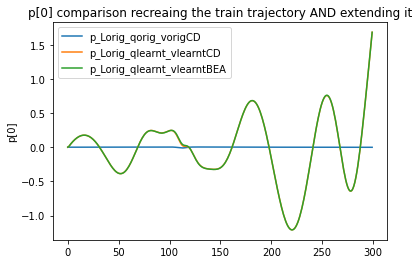

In [53]:
plt.plot(p_Lorig_qorig_vorigCD_extra[0,:], label="p_Lorig_qorig_vorigCD")
plt.plot(p_Lorig_qlearnt_vlearntCD_extra[0,:], label="p_Lorig_qlearnt_vlearntCD")
plt.plot(p_Lorig_qlearnt_vlearntBEA_extra[0,:], label="p_Lorig_qlearnt_vlearntBEA")
plt.legend(loc="upper left")
plt.ylabel('p[0]')
plt.title('p[0] comparison recreaing the train trajectory AND extending it')

print(p_Lorig_qorig_vorigCD_extra[0,0])
print(p_Lorig_qlearnt_vlearntCD_extra[0,0])
print(p_Lorig_qlearnt_vlearntBEA_extra[0,0])



Hamiltonian plots in time (including backward error)

In [54]:

from Hamiltonian_Identification import *
def learned_continuous_Lagrangian(q,qdot): 
    q0 = q-stepsize/2*qdot
    q1 = q+stepsize/2*qdot    
    return model.learned_lagrangian(params)(q0,q1)/stepsize
    
H_ref = Hamiltonian_from_L(system_lagrangian)
H_learnt    = Hamiltonian_from_L(learned_continuous_Lagrangian)
HBEA  = Hamiltonian_from_L(lambda q,qdot: L_BEA2d(learned_continuous_Lagrangian,stepsize)(jnp.hstack([q,qdot])))

H_Ref = jit(H_ref)
H_learnt = jit(H_learnt)
HBEA = jit(HBEA)

In [55]:

def H_simulation_tests(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start,vlearntbea):
    #v0_start = v0_train
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T


    Horig_qorig_vorigCD = np.zeros((number_steps))
    Horig_qorig_vorigCD[0] = H_ref( orig_traj[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  (-orig_traj[:,k-1]+orig_traj[:,k+1])/2/stepsize
        qk = orig_traj[:,k]
        Horig_qorig_vorigCD[k] = H_ref( qk, vk)

    Hbea_qlearnt_vlearntCD = np.zeros((number_steps))
    Hbea_qlearnt_vlearntCD[0] = HBEA( traj_from_learnt_Ld[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        Hbea_qlearnt_vlearntCD[k] = HBEA( qk, vk)

    Hbea_qlearnt_vlearntBEA = np.zeros((number_steps))
    Hbea_qlearnt_vlearntBEA[0] = HBEA( traj_from_learnt_Ld[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  vlearntbea[:,k]
        qk = traj_from_learnt_Ld[:,k]
        Hbea_qlearnt_vlearntBEA[k] = HBEA( qk, vk)

    return Horig_qorig_vorigCD,  Hbea_qlearnt_vlearntCD, Hbea_qlearnt_vlearntBEA
    



In [56]:
Horig_qorig_vorigCD,  Hbea_qlearnt_vlearntCD, Hbea_qlearnt_vlearntBEA = H_simulation_tests(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train,vlearnt_bea)

print('Horig',Horig_qorig_vorigCD[0],Horig_qorig_vorigCD[1])
print('Hbea',Hbea_qlearnt_vlearntCD[0],Hbea_qlearnt_vlearntCD[1])
print('Hbea',Hbea_qlearnt_vlearntBEA[0],Hbea_qlearnt_vlearntBEA[1])


Horig 9.760990861377433 9.760990920207284
Hbea 259.85331808155405 259.85331553756765
Hbea 259.85331808155405 259.85331577808955


Text(0.5, 1.0, 'H ERROR comparison for recreated train trajectory ')

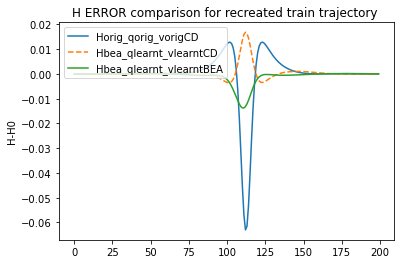

In [62]:
plt.plot(Horig_qorig_vorigCD- Horig_qorig_vorigCD[0]*jnp.ones((N)),label="Horig_qorig_vorigCD")
plt.plot(Hbea_qlearnt_vlearntCD - Hbea_qlearnt_vlearntCD[0]*jnp.ones((N)), '--', label="Hbea_qlearnt_vlearntCD")
plt.plot(Hbea_qlearnt_vlearntBEA - Hbea_qlearnt_vlearntBEA[0]*jnp.ones((N)), label="Hbea_qlearnt_vlearntBEA")

plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR comparison for recreated train trajectory ')

Now with some prediction

In [58]:
Horig_qorig_vorigCD_extra,Hbea_qlearnt_vlearntCD_extra, Hbea_qlearnt_vlearntBEA_extra = H_simulation_tests(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train,vlearnt_bea_extra)

print('Horig',Horig_qorig_vorigCD_extra[0],Horig_qorig_vorigCD_extra[1])
print('Hbea',Hbea_qlearnt_vlearntCD_extra[0],Hbea_qlearnt_vlearntCD_extra[1])
print('Hbea',Hbea_qlearnt_vlearntBEA_extra[0],Hbea_qlearnt_vlearntBEA_extra[1])


Horig 9.760990861377433 9.760990920207284
Hbea 259.85331808155405 259.85331553756765
Hbea 259.85331808155405 259.85331577808955


Text(0.5, 1.0, 'H ERROR comparison for recreated train trajectory AND a prediction')

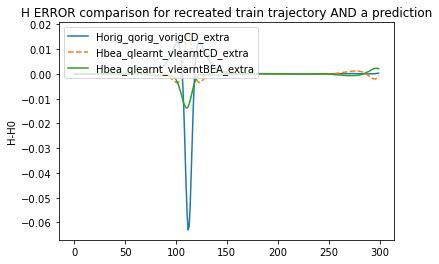

In [59]:
plt.plot(Horig_qorig_vorigCD_extra- Horig_qorig_vorigCD_extra[0]*jnp.ones((N_simul_after_learning)),label="Horig_qorig_vorigCD_extra")
plt.plot(Hbea_qlearnt_vlearntCD_extra - Hbea_qlearnt_vlearntCD_extra[0]*jnp.ones((N_simul_after_learning)), '--', label="Hbea_qlearnt_vlearntCD_extra")
plt.plot(Hbea_qlearnt_vlearntBEA_extra - Hbea_qlearnt_vlearntBEA_extra[0]*jnp.ones((N_simul_after_learning)), label="Hbea_qlearnt_vlearntBEA_extra")

plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR comparison for recreated train trajectory AND a prediction')

In [63]:
import os
import pickle
from pathlib import Path

approach = "DLNN" # LNN, DLNN, or SymDLNN
group = "A" # A, B, C, D, or E
path_to_results = os.path.join("results_final", group, approach)
Path(path_to_results).mkdir(parents=True, exist_ok=True)

pkl_filename = os.path.join(path_to_results, "results_dict.pkl")


# DLNN version for cartpend
dict_to_save = {
    "train_trajectory": train_trajectory,
    "test_trajectory": test_trajectory,
    "train_losses_record": train_losses_record,
    "test_losses_record": test_losses_record,
    "q_model_SVI_Q_q0_q1_scipy": q_model_SVI_Q_q0_q1_scipy,
    "q_model_SVI_Q_q0_q1_scipy2": q_model_SVI_Q_q0_q1_scipy2,
    "train_trajectory_extra": train_trajectory_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra": q_model_SVI_Q_q0_q1_scipy_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra2": q_model_SVI_Q_q0_q1_scipy_extra2,
    "p_Lorig_qorig_vorigCD": p_Lorig_qorig_vorigCD,
    "p_Lorig_qlearnt_vlearntCD": p_Lorig_qlearnt_vlearntCD,
    "p_Lorig_qlearnt_vlearntBEA": p_Lorig_qlearnt_vlearntBEA,
    "p_Lbea_qorig_vorigBEA": p_Lbea_qorig_vorigBEA,
    "p_Lbea_qlearnt_vlearntCD": p_Lbea_qlearnt_vlearntCD,
    "p_Lbea_qlearnt_vlearntBEA": p_Lbea_qlearnt_vlearntBEA,
    "vorig_bea": vorig_bea,
    "vlearnt_bea": vlearnt_bea,

    "p_Lorig_qorig_vorigCD_extra": p_Lorig_qorig_vorigCD_extra,
    "p_Lorig_qlearnt_vlearntCD_extra": p_Lorig_qlearnt_vlearntCD_extra,
    "p_Lorig_qlearnt_vlearntBEA_extra": p_Lorig_qlearnt_vlearntBEA_extra,
    "vlearnt_bea_extra": vlearnt_bea_extra,

    "Horig_qorig_vorigCD_extra": Horig_qorig_vorigCD_extra, 
    "Hbea_qlearnt_vlearntCD_extra": Hbea_qlearnt_vlearntCD_extra, 
    "Hbea_qlearnt_vlearntBEA_extra": Hbea_qlearnt_vlearntBEA_extra,


}

with open(pkl_filename, "wb") as fh:
    pickle.dump(dict_to_save, fh)
